# PROGRAM OPTIMASI LOGISTIK KURIR

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import joblib
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

#  KONFIGURASI AWAL
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

### 1. DATA COLLECTING

In [2]:
print("\n[STEP 1] Data Collecting...")
csv_files = glob.glob('*.csv')
if not csv_files:
    print("[ERROR] File CSV tidak ditemukan. Pastikan file ada di folder yang sama.")
    exit()
file_name = csv_files[0]
print(f"[INFO] Menggunakan file: {file_name}")


[STEP 1] Data Collecting...
[INFO] Menggunakan file: Order.completed.20260101_20260131.csv


### 2. DATA LOADING

In [3]:
print("\n[STEP 2] Data Loading...")
# Membaca file dan membersihkan karakter encoding
df = pd.read_csv(file_name, sep=None, engine='python', encoding='utf-8-sig')
df.columns = df.columns.str.replace(r'[^a-zA-Z0-9\s]', '', regex=True).str.strip()

print("\n" + "="*40)
print("   LAPORAN DATA MENTAH (SEBELUM CLEANING)")
print("="*40)
print(f"Jumlah Baris Awal : {df.shape[0]}")
print(f"Jumlah Kolom Awal : {df.shape[1]}")
print("-" * 40)
# Menampilkan info tipe data awal
print(df.info()) 
print("-" * 40)


[STEP 2] Data Loading...

   LAPORAN DATA MENTAH (SEBELUM CLEANING)
Jumlah Baris Awal : 1033
Jumlah Kolom Awal : 49
----------------------------------------
<class 'pandas.DataFrame'>
RangeIndex: 1033 entries, 0 to 1032
Data columns (total 49 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   No Pesanan                                                  1033 non-null   str    
 1   Status Pesanan                                              1033 non-null   str    
 2   Shipped by Advance Fulfilment                               1033 non-null   str    
 3   Status Pembatalan Pengembalian                              4 non-null      str    
 4   No Resi                                                     1033 non-null   str    
 5   Opsi Pengiriman                                             1033 non-null   str    
 6   Antar ke counter pickup      

### 3. DATA CLEANING & FEATURE ENGINEERING

In [4]:
print("\n[STEP 3] Cleaning & Feature Engineering...")

# A. Identifikasi Kolom Otomatis
def find_col(keys, cols):
    for k in keys:
        for c in cols:
            if k.lower() in c.lower(): return c
    return cols[0]

c_id = find_col(['No Pesanan'], df.columns)
c_berat = find_col(['Total Berat'], df.columns)
c_bayar = find_col(['Total Pembayaran'], df.columns)
c_harga_produk = find_col(['Total Harga Produk'], df.columns)
c_diskon_ongkir = find_col(['Estimasi Potongan'], df.columns)
c_qty = find_col(['Jumlah Produk'], df.columns)
c_opsi = find_col(['Opsi Pengiriman'], df.columns)
c_kota = find_col(['Kota', 'Kabupaten'], df.columns)
c_waktu = find_col(['Waktu Pesanan Dibuat'], df.columns)

# B. Hapus Duplikat
df_clean = df.drop_duplicates(subset=[c_id]).copy()

# C. Fungsi Pembersih Angka
def clean_num(val):
    if pd.isna(val): return 0.0
    s = str(val).lower().replace(' gr','').replace(' kg','').replace('.','').replace(',','.').replace('rp','').strip()
    try:
        n = float(s)
        return n
    except: return 0.0

# 1. Cleaning Angka Dasar
df_clean['Berat_KG'] = df_clean[c_berat].apply(clean_num)
# Koreksi: Jika berat > 100, asumsi input adalah Gram, konversi ke KG
df_clean['Berat_KG'] = np.where(df_clean['Berat_KG'] > 100, df_clean['Berat_KG']/1000, df_clean['Berat_KG'])

df_clean['Total_Bayar'] = df_clean[c_bayar].apply(clean_num)
df_clean['Harga_Produk'] = df_clean[c_harga_produk].apply(clean_num)
df_clean['Diskon_Ongkir'] = df_clean[c_diskon_ongkir].apply(clean_num)
df_clean['Qty'] = df_clean[c_qty].apply(clean_num)

# --- FITUR CERDAS (FEATURE ENGINEERING) ---

# 2. Rasio Harga per KG
df_clean['Harga_per_KG'] = df_clean['Total_Bayar'] / (df_clean['Berat_KG'] + 0.001)

# 3. Fitur Waktu (Jam Pemesanan)
try:
    df_clean['Jam_Pesan'] = pd.to_datetime(df_clean[c_waktu], errors='coerce').dt.hour.fillna(12)
except:
    df_clean['Jam_Pesan'] = 12

# 4. Fitur Lokasi (Logika Bandung)
df_clean['Kota_Clean'] = df_clean[c_kota].astype(str).str.upper().str.strip()

# Deteksi Kota Penjual (Berdasarkan pengiriman Instant terbanyak)
subset_instant = df_clean[df_clean[c_opsi].astype(str).str.lower().str.contains('instant')]
if len(subset_instant) > 0:
    kota_penjual = subset_instant['Kota_Clean'].mode()[0]
else:
    kota_penjual = df_clean['Kota_Clean'].mode()[0]

df_clean['Is_Same_City'] = (df_clean['Kota_Clean'] == kota_penjual).astype(int)

# Area Bandung Raya (Cimahi, Lembang, dll)
bandung_raya = ['BANDUNG', 'CIMAHI', 'SUMEDANG', 'SOREANG', 'LEMBANG', 'PADALARANG']
df_clean['Is_Bandung_Area'] = df_clean['Kota_Clean'].apply(lambda x: 1 if any(k in x for k in bandung_raya) else 0)

# 5. Mapping Target Layanan
def map_target(opsi):
    opsi = str(opsi).lower()
    if 'instant' in opsi: return 'Instant'
    if 'same' in opsi: return 'Same Day'
    if 'next' in opsi or 'yes' in opsi: return 'Next Day'
    if any(k in opsi for k in ['kargo', 'hemat', 'economy']): return 'Hemat / Kargo'
    return 'Reguler'

df_clean['Target_Layanan'] = df_clean[c_opsi].apply(map_target)

# Filter Data Valid
df_final = df_clean[(df_clean['Total_Bayar'] > 0) & (df_clean['Berat_KG'] > 0)].copy()

# Fitur yang digunakan untuk Training
features = [
    'Berat_KG', 'Total_Bayar', 'Harga_Produk', 'Diskon_Ongkir', 
    'Qty', 'Harga_per_KG', 'Is_Same_City', 'Is_Bandung_Area', 'Jam_Pesan'
]

print("\n" + "="*40)
print("   LAPORAN DATA BERSIH (SETELAH CLEANING)")
print("="*40)
print(f"Jumlah Baris Akhir : {df_final.shape[0]} (Duplikat dihapus)")
print(f"Kota Penjual       : {kota_penjual}")
print("-" * 40)
# Menampilkan info hanya untuk kolom yang relevan
print(df_final[features + ['Target_Layanan']].info()) 
print("-" * 40)


[STEP 3] Cleaning & Feature Engineering...

   LAPORAN DATA BERSIH (SETELAH CLEANING)
Jumlah Baris Akhir : 776 (Duplikat dihapus)
Kota Penjual       : KOTA BANDUNG
----------------------------------------
<class 'pandas.DataFrame'>
Index: 776 entries, 0 to 1032
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Berat_KG         776 non-null    float64
 1   Total_Bayar      776 non-null    float64
 2   Harga_Produk     776 non-null    float64
 3   Diskon_Ongkir    776 non-null    float64
 4   Qty              776 non-null    float64
 5   Harga_per_KG     776 non-null    float64
 6   Is_Same_City     776 non-null    int64  
 7   Is_Bandung_Area  776 non-null    int64  
 8   Jam_Pesan        776 non-null    int32  
 9   Target_Layanan   776 non-null    str    
dtypes: float64(6), int32(1), int64(2), str(1)
memory usage: 63.7 KB
None
----------------------------------------


### 4. EXPLORATORY DAN EXPLANATORY DATA ANALYSIS (EDA)


[STEP 4] Membuat Visualisasi Analisis...


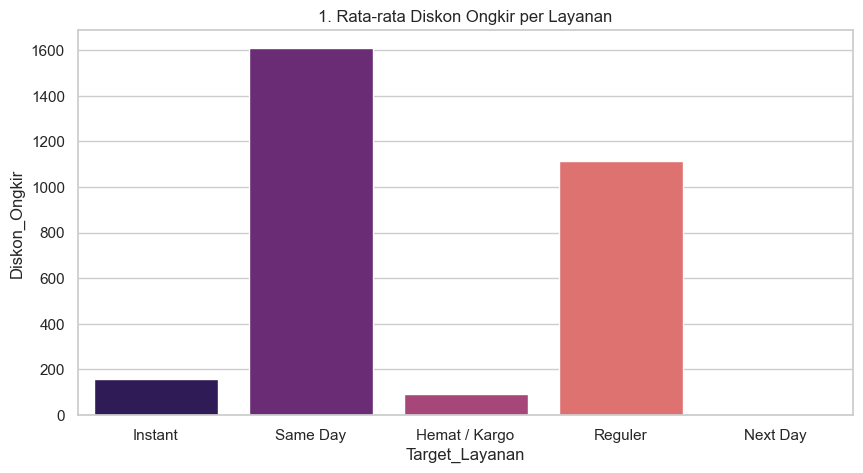

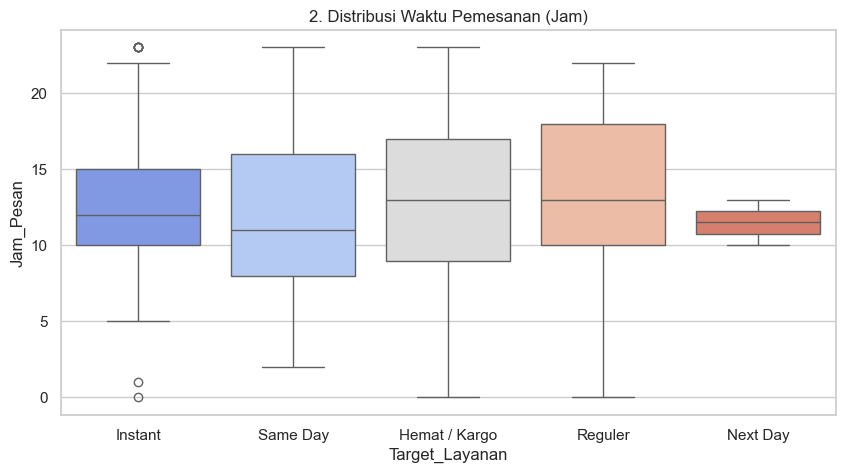

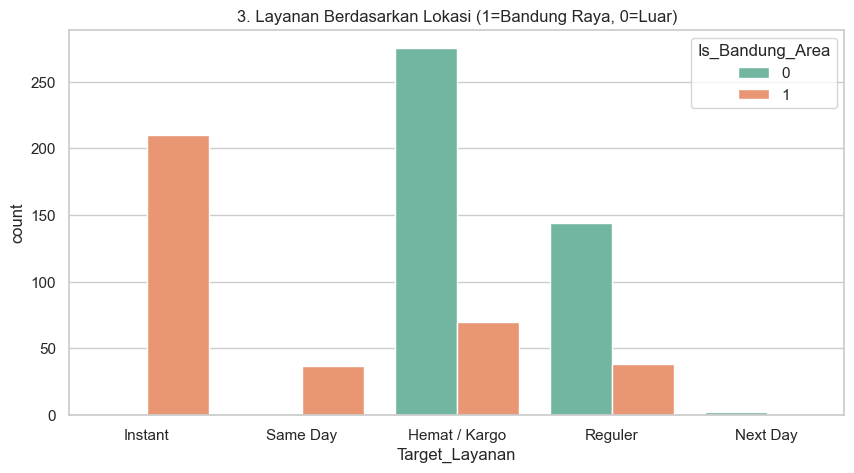

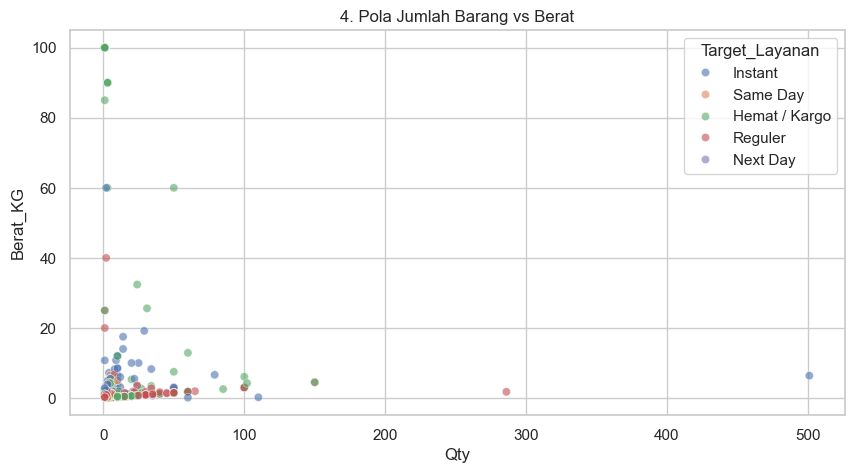

In [5]:
print("\n[STEP 4] Membuat Visualisasi Analisis...")

# 1. Bar Chart: Diskon Ongkir
plt.figure(figsize=(10, 5))
sns.barplot(data=df_final, x='Target_Layanan', y='Diskon_Ongkir', palette='magma', errorbar=None)
plt.title('1. Rata-rata Diskon Ongkir per Layanan')
plt.show()

# 2. Boxplot: Jam Pesan
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_final, x='Target_Layanan', y='Jam_Pesan', palette='coolwarm')
plt.title('2. Distribusi Waktu Pemesanan (Jam)')
plt.show()

# 3. Countplot: Area Bandung
plt.figure(figsize=(10, 5))
sns.countplot(data=df_final, x='Target_Layanan', hue='Is_Bandung_Area', palette='Set2')
plt.title('3. Layanan Berdasarkan Lokasi (1=Bandung Raya, 0=Luar)')
plt.show()

# 4. Scatter Plot: Qty vs Berat
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df_final, x='Qty', y='Berat_KG', hue='Target_Layanan', alpha=0.6)
plt.title('4. Pola Jumlah Barang vs Berat')
plt.show()

### 5. TRAINING MODEL (RANDOM FOREST CLASSIFIER)

In [6]:
print("\n[STEP 5] Training AI (High Accuracy)...")

X = df_final[features]
y = df_final['Target_Layanan']

# Split Data (80% Training, 20% Testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Inisialisasi Model
model = RandomForestClassifier(n_estimators=300, max_depth=20, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

# Evaluasi
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"[INFO] Akurasi Model: {acc*100:.2f}%")
print("\n[INFO] Fitur Paling Berpengaruh:")
importance = dict(zip(features, np.round(model.feature_importances_, 3)))
for k, v in sorted(importance.items(), key=lambda item: item[1], reverse=True):
    print(f" - {k}: {v}")


[STEP 5] Training AI (High Accuracy)...
[INFO] Akurasi Model: 83.33%

[INFO] Fitur Paling Berpengaruh:
 - Diskon_Ongkir: 0.266
 - Is_Bandung_Area: 0.141
 - Harga_per_KG: 0.14
 - Total_Bayar: 0.12
 - Berat_KG: 0.091
 - Harga_Produk: 0.09
 - Jam_Pesan: 0.059
 - Qty: 0.056
 - Is_Same_City: 0.037


### 6. DEPLOYMENT DAN MONITORING

In [ ]:
print("\n[STEP 6] Sistem Prediksi Siap.")
joblib.dump(model, 'model_rf_bandung.pkl')

print("\n" + "="*50)
print(f"   SISTEM PREDIKSI (KOTA PENJUAL: {kota_penjual})")
print("="*50)

while True:
    try:
        print("\n--- Input Data Paket ---")
        b = float(input("Berat (KG)       : "))
        h_produk = float(input("Harga Produk (Rp): ")) 
        qty = float(input("Jumlah Barang    : "))
        diskon = float(input("Est. Diskon (Rp) : ") or 0)
        j = float(input("Jam Pesan (0-23) : "))
        kota_txt = input("Kota Tujuan      : ").strip().upper()
        
        # Kalkulasi Fitur Turunan
        # Estimasi total bayar = Harga Produk + 10rb (estimasi ongkir) - Diskon
        total_bayar = max(0, h_produk + 10000 - diskon)
        p_kg = total_bayar / (b + 0.001)
        
        # Logika Lokasi
        is_same = 1 if kota_txt == kota_penjual else 0
        is_bdg_area = 1 if any(k in kota_txt for k in bandung_raya) else 0
        
        # DataFrame Input
        input_data = pd.DataFrame([[b, total_bayar, h_produk, diskon, qty, p_kg, is_same, is_bdg_area, j]], columns=features)
        
        # Prediksi
        hasil = model.predict(input_data)[0]
        proba = model.predict_proba(input_data).max()
        
        print(f"\n[HASIL PREDIKSI]")
        print(f"Layanan Terbaik   : {hasil}")
        print(f"Tingkat Keyakinan : {proba*100:.1f}%")
        
        opsi = input("\nCoba lagi? (y/n): ").lower()
        if opsi != 'y': 
            break
            
    except Exception as e:
        print(f"[ERROR] Input tidak valid: {e}")
        break

print("\nProgram Selesai.")


[STEP 6] Sistem Prediksi Siap.

   SISTEM PREDIKSI (KOTA PENJUAL: KOTA BANDUNG)

--- Input Data Paket ---
